# AtariSpace

This task will not "play" atari but rather simply explore it. That is, there are no rewards, just a (nearly) passive viewing of the different games. The network can take actions within a game, or can cycle between the list of games, but is not rewarded by game score. Instead the network simply watches the games and tries to predict future frames. 

## VNet
This "visual" network is simply an autoencoder. The bottleneck layer is treated as a latent variable (LV). It is convolutional with tied encoder-decoder weights. 

## HNet
This "hippocampal" network takes in the current LV and tries to predict the next LV. This assumes that VNet is relatively constant (low learning rate or frozen). This should have a high LR, and use memory augmentation to preserve long-term dependencies.

## MNet
A small "motor"  network will be trained to maximize prediction errors as a method to encourage exploration. Prediction error is a positive scalar and there is an ideal "Goldilocks zone" for exploration which we approximate with an Erlang distribution.
This could just be random actions, but if any useful exploration policies are learned then great. 

## Environment notes
Any input from any game is allowed (0-9), and ideally MNet should learn which inputs are actually useful in a given game. Two more inputs will allow for cycling between games.

In [1]:
# !pip install -r requirements.txt

In [2]:
import gymnasium as gym
import math
import random, datetime, os, copy, time
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import pickle

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.distributions as dist

import AtariSpace

torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("using " + str(device))

using cuda


A.L.E: Arcade Learning Environment (version 0.10.1+unknown)
[Powered by Stella]


using cuda


In [3]:
# conv2d design testing
# ideally out convolutions should work with the input image size to only produce integers here. This will help a lot in the ConvTranspose2d decoder!
current_frame = torch.zeros((241,153)).to(device)
def conv_output_shape(h_w, kernel_size=1, stride=1, pad=0, dilation=1):
    if type(kernel_size) is not tuple:
        kernel_size = (kernel_size, kernel_size)
    h = ((h_w[0] + (2 * pad) - ( dilation * (kernel_size[0] - 1) ) - 1 )/ stride) + 1
    w = ((h_w[1] + (2 * pad) - ( dilation * (kernel_size[1] - 1) ) - 1 )/ stride) + 1
    return h, w
t1 = conv_output_shape(current_frame.shape,kernel_size=5, stride=2)
t2 = conv_output_shape(t1,kernel_size=3, stride=2)
t3 = conv_output_shape(t2,kernel_size=3, stride=2)
print(t1)
print(t2)
print(t3)
flatsz = int(np.prod(t3)*32)
print(flatsz)

(119.0, 75.0)
(59.0, 37.0)
(29.0, 18.0)
16704


In [4]:
class TiedConvAE(nn.Module):
    #This will be a convolutional AE with tied encoder-decoder weights. Encoder can optionally be frozen.

    def __init__(self, output_dim=(512)):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=2,bias=False),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2,bias=False),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=2,bias=False),
            nn.Flatten(),
            nn.Linear(flatsz, 10000, bias=False),
            nn.Tanh(),
            nn.Linear(10000, output_dim, bias=False),
        )
        self.decoder = nn.Sequential(
            nn.Linear(output_dim, 10000, bias=False),
            nn.Tanh(),
            nn.Linear(10000,flatsz,bias=False),
            # nn.Unflatten(1,(1,241,153)),
            nn.Unflatten(1,(32,int(t3[0]),int(t3[1]))),
            nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=3, stride=2,bias=False),
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=2,bias=False),
            nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=5, stride=2,bias=False),
        )
            
        # Tie the weights for Conv2d and ConvTranspose2d layers, and Linear layers in one loop
        for enc_layer, dec_layer in zip(self.encoder, self.decoder):
            if isinstance(enc_layer, nn.Conv2d) and isinstance(dec_layer, nn.ConvTranspose2d):
                dec_layer.weight = nn.Parameter(enc_layer.weight)
            elif isinstance(enc_layer, nn.Linear) and isinstance(dec_layer, nn.Linear):
                dec_layer.weight = nn.Parameter(enc_layer.weight.t())

    def forward(self, input):
        embedded_frame = self.encoder(input)
        reconstructed_frame = self.decoder(embedded_frame)
        return embedded_frame, reconstructed_frame

    def backward(self, embedded_frame):
        return self.decoder(embedded_frame)
        
vnet = TiedConvAE().to(device)
VLoss = nn.L1Loss()
VOptim = optim.Adam(vnet.parameters())
print(vnet)

TiedConvAE(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(2, 2), bias=False)
    (1): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (3): Flatten(start_dim=1, end_dim=-1)
    (4): Linear(in_features=16704, out_features=10000, bias=False)
    (5): Tanh()
    (6): Linear(in_features=10000, out_features=512, bias=False)
  )
  (decoder): Sequential(
    (0): Linear(in_features=512, out_features=10000, bias=False)
    (1): Tanh()
    (2): Linear(in_features=10000, out_features=16704, bias=False)
    (3): Unflatten(dim=1, unflattened_size=(32, 29, 18))
    (4): ConvTranspose2d(32, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (5): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (6): ConvTranspose2d(16, 1, kernel_size=(5, 5), stride=(2, 2), bias=False)
  )
)


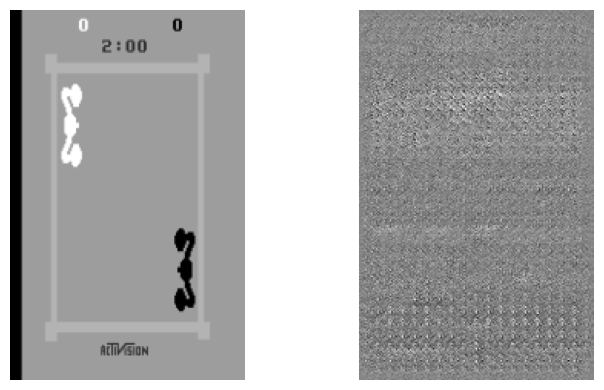

Iteration: 9, Loss: 0.6431376934051514


In [5]:
# quick test / pretrain of VNet

pretrain = False

if pretrain:
    ntrain =100000
    nview = 1000
elif not pretrain:
    ntrain = 10
    nview = 1

for i in range(ntrain):
    AtariSpace.g = np.random.randint(0,len(AtariSpace.games))
    frame = AtariSpace.AtariPress(0)

    LV, recon_frame = vnet(AtariSpace.current_frame)

    vloss = VLoss(recon_frame,AtariSpace.current_frame)
    VOptim.zero_grad()
    vloss.backward()
    VOptim.step()
    
    if i % nview == 0:  
        recon = recon_frame.detach().cpu()  # Detach and move to CPU for visualization
        if torch.isnan(recon).any():
            raise Exception("NaN value detected in the reconstruction!")
        
        # Visualize original and reconstructed frames
        AtariSpace.live_plot([AtariSpace.current_frame, recon])
        print(f'Iteration: {i}, Loss: {vloss.item()}')
            
if pretrain: torch.save(vnet.state_dict(),'VNet_saved')

In [6]:
vnet.load_state_dict(torch.load('VNet_saved'))

/data/mica1/01_programs/tmp/ipykernel_23298/1018058311.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vnet.load_state_dict(torch.load('VNet_saved'))


<All keys matched successfully>

In [7]:
class MemoryAugmentedPredictor(nn.Module):
    def __init__(self, latent_dim=512, action_dim=AtariSpace.possible_actions, memory_size=1000):
        super(MemoryAugmentedPredictor, self).__init__()
        
        # Action encoding
        self.action_encoder = nn.Linear(action_dim, latent_dim)
        
        # External memory (here using a simple key-value store approach)
        self.memory_keys = nn.Parameter(torch.randn(memory_size, latent_dim))
        self.memory_values = nn.Parameter(torch.randn(memory_size, latent_dim))
        
        # Output layer to predict the next latent representation
        self.output_layer = nn.Linear(latent_dim, latent_dim)
        
    def scaled_dot_product_attention(self, Q, K, V):
        """Compute scaled dot-product attention"""
        d_k = Q.size(-1)  # Dimension of query/key
        scores = torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(torch.tensor(d_k, dtype=torch.float32))
        attn_weights = F.softmax(scores, dim=-1)
        output = torch.matmul(attn_weights, V)
        return output, attn_weights

    def forward(self, embedded_frame, action):
        # Encode action and sum with embedded frame
        action_emb = self.action_encoder(action)
        combined_input = embedded_frame + action_emb  # Shape: (batch_size, latent_dim)
        
        # Use the current embedded frame as the query (Q)
        Q = combined_input.unsqueeze(1)  # Adding the timestep dimension (batch_size, 1, latent_dim)

        # Memory keys and values from stored memory
        K = self.memory_keys  # Shape: (memory_size, latent_dim)
        V = self.memory_values  # Shape: (memory_size, latent_dim)

        # Apply scaled dot-product attention
        memory_out, _ = self.scaled_dot_product_attention(Q, K, V)

        # Combine memory output with the current embedded frame
        combined_output = memory_out.squeeze(1) + embedded_frame  # Add the current frame’s embedding

        # Output layer to predict the next latent representation
        prediction = self.output_layer(combined_output)
        
        return prediction

hnet = MemoryAugmentedPredictor().to(device)
HLoss = nn.MSELoss()
HOptim = optim.Adam(hnet.parameters())#, lr=0.05)
print(hnet)

MemoryAugmentedPredictor(
  (action_encoder): Linear(in_features=9, out_features=512, bias=True)
  (output_layer): Linear(in_features=512, out_features=512, bias=True)
)


ReinforcementActionNetwork(
  (online): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=9, bias=True)
  )
)


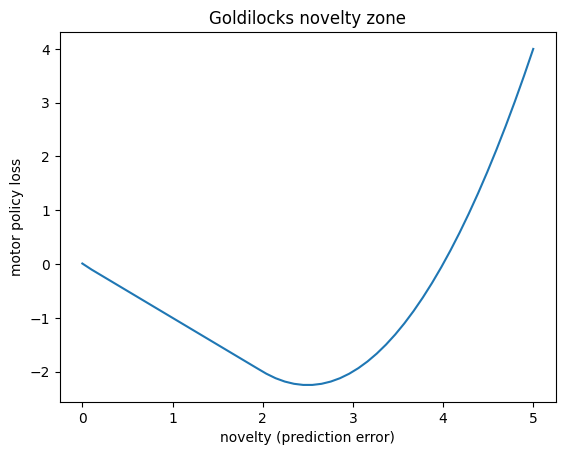

In [8]:
class ReinforcementActionNetwork(nn.Module):
    def __init__(self, input_dim=512, output_dim=AtariSpace.possible_actions):
        super(ReinforcementActionNetwork, self).__init__()
        self.online = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim),
        )

    def forward(self, embedded_frame):
        # Output a distribution over actions
        action_logits = self.online(embedded_frame)
        action_probs = F.log_softmax(action_logits, dim=-1)
        return action_probs

    def select_action(self, embedded_frame):
        action_probs = self.forward(embedded_frame)
        action_dist = dist.Categorical(action_probs)
        action = action_dist.sample()  # Sample an action
        return action, action_probs

# Instantiate the network and optimizer
mnet = ReinforcementActionNetwork().to(device)
MOptim = optim.Adam(mnet.parameters(), lr=0.001)

# Example of a reinforcement-style loss function
def policy_gradient_loss(log_prob, reward):
    return log_prob * reward

def goldilocks_loss(hloss, min_hloss=0.1, max_hloss=2.0):
    """
    Encourages `hloss` to be in the 'Goldilocks' zone between min_hloss and max_hloss.
    Too small hloss means not enough exploration, too large means erratic behavior.
    """
    # Ensure hloss is within the Goldilocks zone
    if hloss < min_hloss:
        # Encourage larger hloss (more exploration)
        loss = (min_hloss - hloss).pow(2)
    elif hloss > max_hloss:
        # Penalize too high hloss (too much exploration, erratic behavior)
        loss = (hloss - max_hloss).pow(2)
    else:
        # Ideal region: no penalty
        loss = 0.0
    
    return loss

# example plot
x = torch.tensor(np.linspace(0,5,num=50))
y = [goldilocks_loss(xx) -xx for xx in x]
plt.plot(x,y)
plt.title("Goldilocks novelty zone")
plt.xlabel("novelty (prediction error)")
plt.ylabel("motor policy loss")

print(mnet)

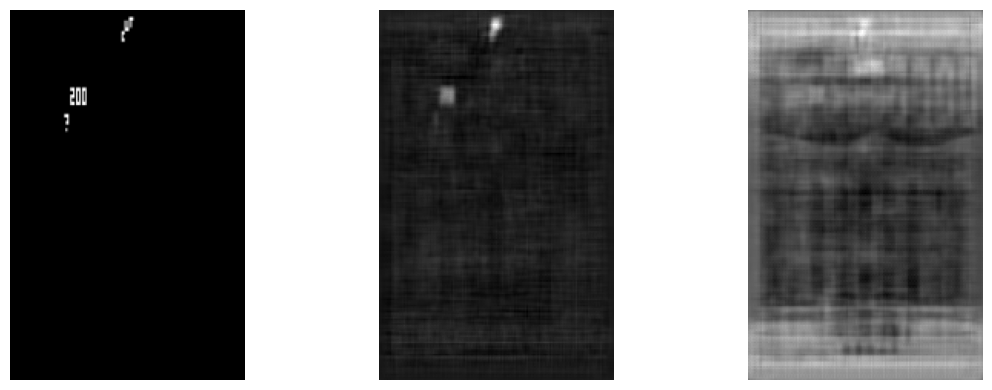

Iteration: 99, VLoss: 0.1283, HLoss: 130465.6328, MLoss: -2855197158309927845888.0000
Elapsed time: 404.09 seconds


In [13]:
# Initialize state
current_LV, recon_frame = vnet(AtariSpace.current_frame)

log = []
t = time.time()
plot_every_n = 1000

for i in range(100000):
    
    # Choose an action
    action, action_probs = mnet.select_action(current_LV)  # Output raw action probabilities

    # Store current frame and perform action in the environment
    current_frame = copy.deepcopy(AtariSpace.current_frame.detach())
    next_frame = AtariSpace.AtariPress(action)
    
    # Visualize reconstruction of current LV
    recon_frame = vnet.backward(current_LV.detach())
    
    # Train VNet to reconstruct the current frame from the current LV (optional)
    vloss = VLoss(recon_frame, current_frame)
    VOptim.zero_grad()
    vloss.backward()
    VOptim.step()
    
    # Make a prediction of the next latent variable using current LV and action
    predicted_LV = hnet(current_LV.detach(), action_probs.detach())
    predicted_frame = vnet.backward(predicted_LV)

    # Get the actual next LV
    next_LV, next_recon_frame = vnet.forward(next_frame)

    # Train HNet to predict next LV from the current LV
    hloss = HLoss(predicted_LV, next_LV.detach())
    HOptim.zero_grad()
    hloss.backward()  # Backpropagate only for hnet
    HOptim.step()

    # Train MNet with Goldilocks loss and policy gradient
    reward = -hloss.detach() + goldilocks_loss(hloss.detach())
    mloss = policy_gradient_loss(action_probs, reward).sum()
    MOptim.zero_grad()
    mloss.backward()  # Backpropagate only for mnet
    MOptim.step()
    
    # Log and visualize
    if i % plot_every_n == 0:
        AtariSpace.live_plot([next_frame, next_recon_frame, predicted_frame])
        print(f"Iteration: {i}, VLoss: {vloss.item():.4f}, HLoss: {hloss.item():.4f}, MLoss: {mloss.item():.4f}")
    log.append([vloss.cpu().detach(), hloss.cpu().detach(), mloss.cpu().detach(), action.cpu().detach(), AtariSpace.g])
    
    # Move to next state
    current_LV = next_LV.clone().detach().requires_grad_()  # Ensure gradients are preserved for new state

elapsed = time.time() - t
print(f"Elapsed time: {elapsed:.2f} seconds")

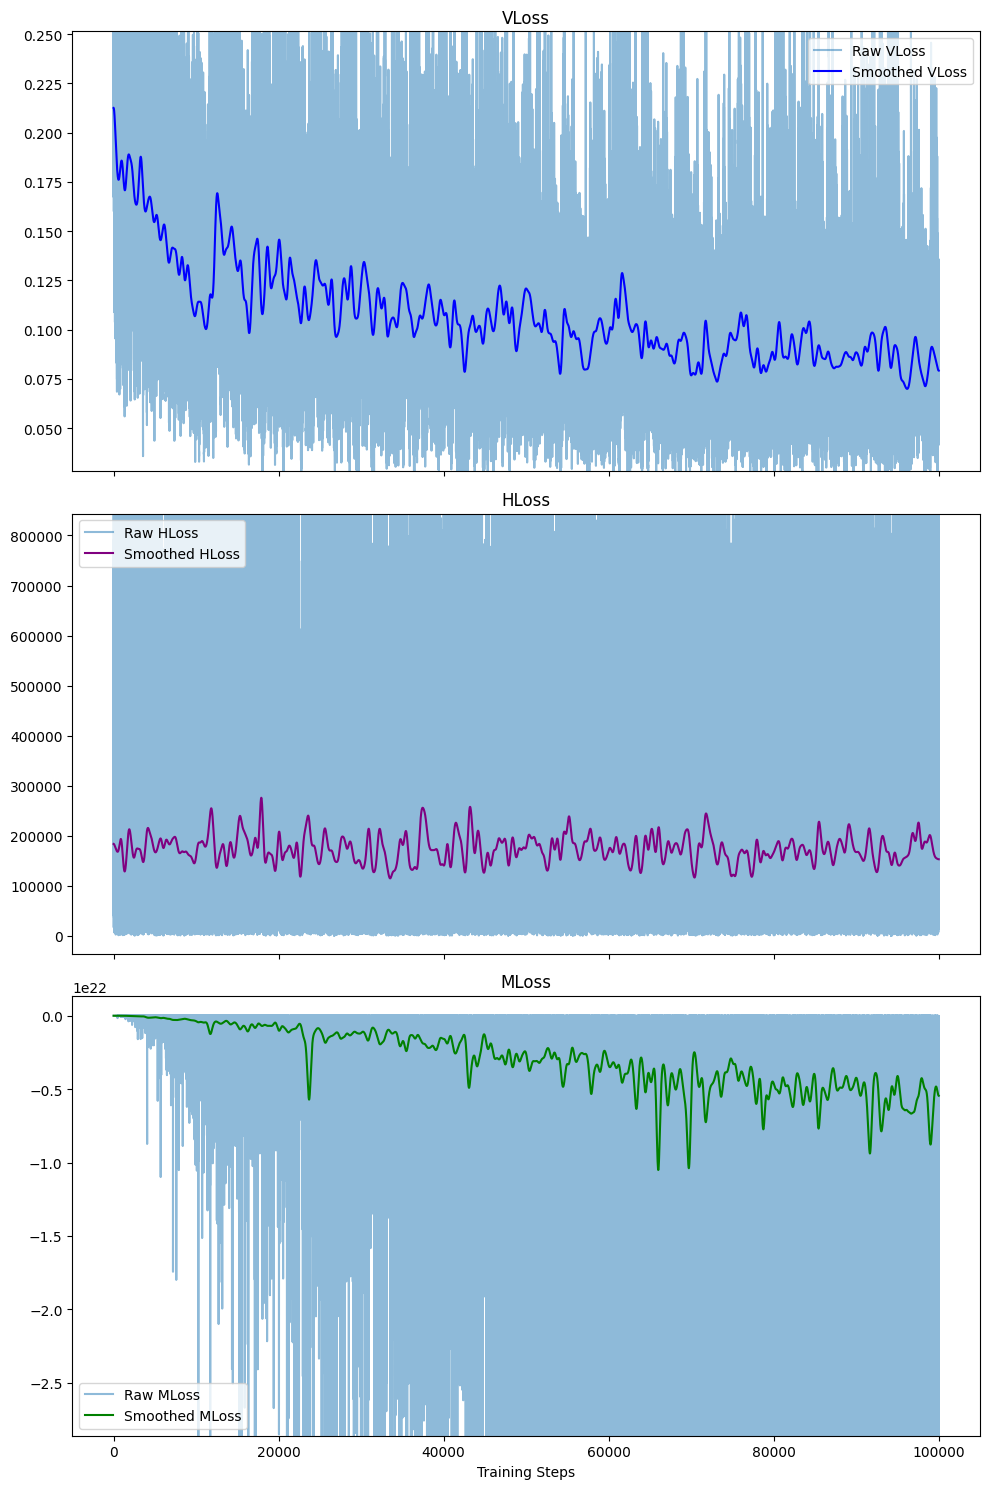

In [16]:
from scipy.ndimage import gaussian_filter1d


def plot_logs(log, smooth_sigma=200):
    """
    Plot the losses (raw and smoothed) from the log data, with y-axis limits set to the 95% range.
    Args:
        log: A list of logged values where each entry contains [vloss, hloss, mloss, ...].
        smooth_sigma: Standard deviation for Gaussian smoothing.
    """
    vloss = [entry[0] for entry in log]
    hloss = [entry[1] for entry in log]
    mloss = [entry[2] for entry in log]
    
    # Smooth the loss values for better visualization
    vloss_smooth = gaussian_filter1d(vloss, sigma=smooth_sigma)
    hloss_smooth = gaussian_filter1d(hloss, sigma=smooth_sigma)
    mloss_smooth = gaussian_filter1d(mloss, sigma=smooth_sigma)
    
    # Compute the 95% range for y-axis limits
    def get_yaxis_limits(data):
        lower, upper = np.percentile(data, [2.5, 97.5])
        margin = 0.05 * (upper - lower)
        return lower - margin, upper + margin
    
    vloss_ylim = get_yaxis_limits(vloss)
    hloss_ylim = get_yaxis_limits(hloss)
    mloss_ylim = get_yaxis_limits(mloss)
    
    # Plot raw and smoothed losses
    fig, axes = plt.subplots(3, 1, figsize=(10, 15), sharex=True)
    
    axes[0].plot(vloss, label="Raw VLoss", alpha=0.5)
    axes[0].plot(vloss_smooth, label="Smoothed VLoss", color="blue")
    axes[0].set_title("VLoss")
    axes[0].set_ylim(vloss_ylim)
    axes[0].legend()
    
    axes[1].plot(hloss, label="Raw HLoss", alpha=0.5)
    axes[1].plot(hloss_smooth, label="Smoothed HLoss", color="purple")
    axes[1].set_title("HLoss")
    axes[1].set_ylim(hloss_ylim)
    axes[1].legend()
    
    axes[2].plot(mloss, label="Raw MLoss", alpha=0.5)
    axes[2].plot(mloss_smooth, label="Smoothed MLoss", color="green")
    axes[2].set_title("MLoss")
    axes[2].set_ylim(mloss_ylim)
    axes[2].legend()
    
    plt.xlabel("Training Steps")
    plt.tight_layout()
    plt.show()

plot_logs(log)

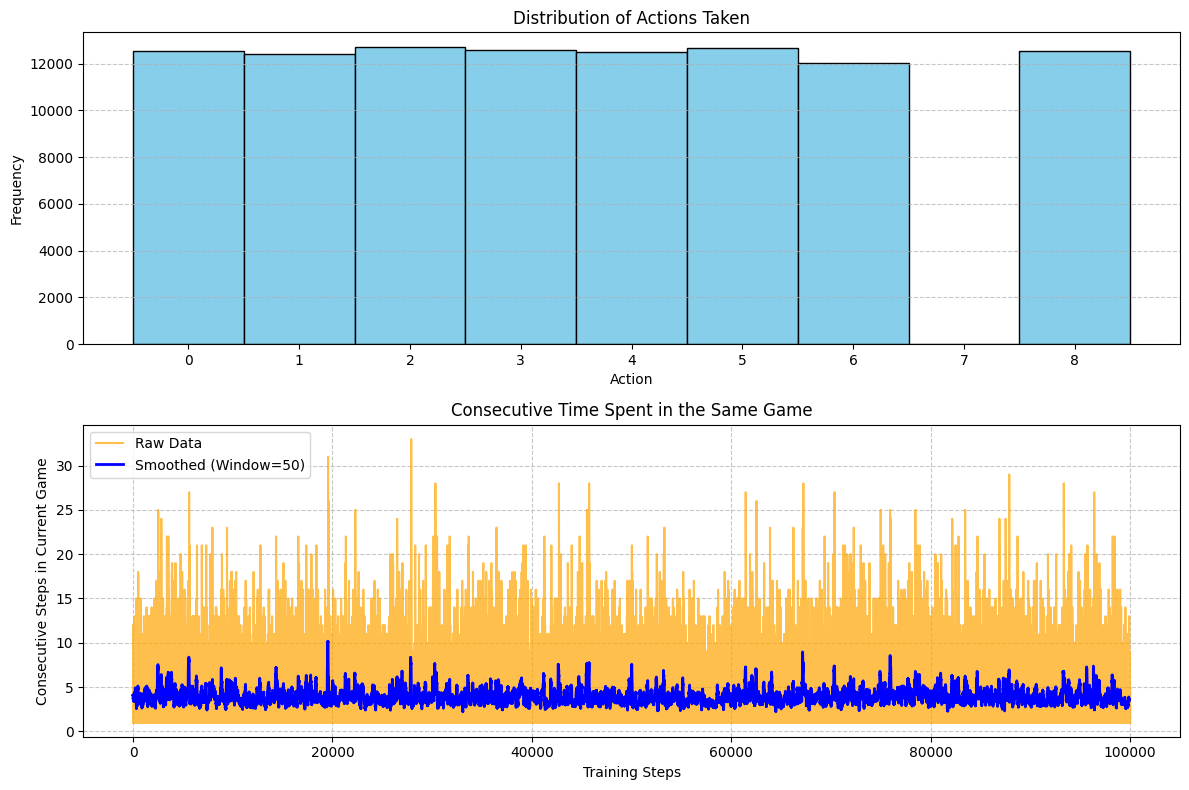

In [ ]:
def moving_average(data, window_size=100):
    cumsum = np.cumsum(np.insert(data, 0, 0))  # Cumulative sum with a leading zero
    return (cumsum[window_size:] - cumsum[:-window_size]) / window_size

# Compute time spent in the same game consecutively (streaks)
game_streaks = []
streak_length = 0
current_game = games[0]

# Compute streak lengths
for game in games:
    if game == current_game:
        streak_length += 1
    else:
        game_streaks.append(streak_length)
        streak_length = 1
        current_game = game
game_streaks.append(streak_length)  # Append the last streak

# Map streaks back to their positions in the training steps
game_streaks_full = []
streak_idx = 0
current_streak_length = game_streaks[streak_idx]

for game in games:
    game_streaks_full.append(current_streak_length)
    current_streak_length -= 1  # Decrease remaining length in current streak
    if current_streak_length == 0:  # Move to the next streak
        streak_idx += 1
        if streak_idx < len(game_streaks):  # Ensure we stay within bounds
            current_streak_length = game_streaks[streak_idx]

# Smooth the data
smoothed_game_streaks = moving_average(game_streaks_full)

# Plot 1: Histogram of actions taken
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.hist(actions, bins=np.arange(max(actions) + 2) - 0.5, color='skyblue', edgecolor='black')
plt.title("Distribution of Actions Taken")
plt.xlabel("Action")
plt.ylabel("Frequency")
plt.xticks(range(max(actions) + 1))  # Ensure all actions are labeled
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Plot 2: Consecutive time spent in the same game with smoothing
plt.subplot(2, 1, 2)
plt.plot(game_streaks_full, label="Raw Data", color='orange', alpha=0.7)
plt.plot(
    range(len(smoothed_game_streaks)), 
    smoothed_game_streaks, 
    label=f"Smoothed (Window=50)", 
    color='blue', 
    linewidth=2
)
plt.title("Consecutive Time Spent in the Same Game")
plt.xlabel("Training Steps")
plt.ylabel("Consecutive Steps in Current Game")
plt.legend()
plt.grid(linestyle='--', alpha=0.7)

# Show the plots
plt.tight_layout()
plt.show()

In [ ]:
# torch.save(vnet.state_dict(),'VNet_saved_memtrained')
# torch.save(hnet.state_dict(),'HNet_saved')
# torch.save(mnet.state_dict(),'MNet_saved')
# with open("log.pkl", "wb") as f: pickle.dump(log, f)

In [12]:
# vnet.load_state_dict(torch.load('VNet_saved'))
# hnet.load_state_dict(torch.load('HNet_saved'))
# mnet.load_state_dict(torch.load('MNet_saved'))
# with open("log.pkl", "rb") as f: log = pickle.load(f)

/data/mica1/01_programs/tmp/ipykernel_23298/433157114.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vnet.load_state_dict(torch.load('VNet_saved'))
/data/mica1/01_progr